<a href="https://colab.research.google.com/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/MiniProject_Group4_mb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project: SVM & Logistic Regression Classification

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

# TO DO

- Try model without departure delay

## Blake
- SVM

## Amber
- Logistic regression

## Megan
- Logistic regression variations and weight plots

## Matt
- Try SVM grid search on a sample of the data 
- `from sklearn.svm import SVC
clf = SVC(kernel='linear', max_iter=500)`
- Vary variables and try again
- Can we do the plots?

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our group's Mini Project uses the same data that we explored during [Lab 1](https://nbviewer.jupyter.org/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/Lab1_Group4.ipynb), which you'll recall came from the U.S. Department of Transportation's Bureau of Transportation Statistics and "tracks the on-time performance of domestic flights operated by large air carriers" during 2015 [Kaggle](https://www.kaggle.com/usdot/flight-delays). 

Our logistic regression and support vector machine models will focus on classifying flights using arrival delay as our response variable. As we noted in Lab 1's Business Understanding section, "Arrival delay serves as the total delay experienced by the flight and accounts for previous delays as well as time that pilots were able to make up in the air."

## 1. Logistic Regression & Support Vector Machine Models

> [50 points] Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.

### 1.1 Setup & Load Data

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import altair as alt

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. 
# Later on we will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
#airlines = pd.read_csv('../Data/airlines.csv')
#airports = pd.read_csv('../Data/airports.csv')
#flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

# Convert string columns to datetime
cols = ["WHEELS_OFF",  
        "WHEELS_ON"] 
df[cols] = df[cols].apply(pd.to_datetime, format = '%H%M', errors='coerce')

# Convert time to numeric for binning of the other times
cols = ["SCHEDULED_DEPARTURE", 
        "DEPARTURE_TIME", 
        "SCHEDULED_ARRIVAL", 
        "ARRIVAL_TIME"]
df[cols] = df[cols].apply(pd.to_numeric)

### 1.2 Create New Variables

The data contains several timestamp and continuous variables that add additional complexity. In order to simplify the data, we will create buckets where appropriate to analyze similar attributes together. 

We first convert `SCHEDULED_DEPARTURE`, `DEPARTURE_TIME`, and `SCHEDULED_ARRIVAL` into buckets based on their timestamp. Because we are trying to predict arrivals we would not have access to the `ARRIVAL_TIME` data.

- **Overnight**: 12:00am - 4:00am
- **Morning**: 4:00am - 11:00am
- **Afternoon**: 11:00am - 4:00pm
- **Evening**: 4:00pm - 12:00am

[Flight] `DISTANCE` is also divided into buckets.

- **Short**: 1-99 miles
- **Medium**: 100-999 miles
- **Long**: 1,000+ miles

In [3]:
# Convert times into buckets for morning, afternoon, and evening as most models cannot handle timestamps.
cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 400, 1100, 1600, 2359]

df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'], 
                                    bins=cut_bins, 
                                    labels=cut_labels, 
                                    include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'], 
                                     bins=cut_bins, 
                                     labels=cut_labels, 
                                     include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'], 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)

# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Look at our data with the buckets
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,1900-01-01 00:15:00,205,194.0,169.0,1448,1900-01-01 04:04:00,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,overnight,evening,morning,Long
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,1900-01-01 00:14:00,280,279.0,263.0,2330,1900-01-01 07:37:00,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,Long
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,1900-01-01 00:34:00,286,293.0,266.0,2296,1900-01-01 08:00:00,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US Airways Inc.,overnight,overnight,morning,Long
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,1900-01-01 00:30:00,285,281.0,258.0,2342,1900-01-01 07:48:00,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,Long
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,1900-01-01 00:35:00,235,215.0,199.0,1448,1900-01-01 02:54:00,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,overnight,overnight,overnight,Long


In [4]:
# Check how many of each bin we have
sched_depart = df['SCHED_DEPARTURE_TIME'].value_counts()
actual_depart = df['ACTUAL_DEPARTURE_TIME'].value_counts()
sched_arrival = df['SCHED_ARRIVAL_TIME'].value_counts()
dist_bucket = df['DISTANCE_BUCKET'].value_counts()

print(sched_depart, '\n\n', actual_depart, '\n\n', sched_arrival, '\n\n', dist_bucket)

morning      2056248
evening      1971869
afternoon    1768922
overnight      22040
Name: SCHED_DEPARTURE_TIME, dtype: int64 

 evening      1999032
morning      1978882
afternoon    1716939
overnight      37560
Name: ACTUAL_DEPARTURE_TIME, dtype: int64 

 evening      2676736
afternoon    1735865
morning      1317709
overnight      88767
Name: SCHED_ARRIVAL_TIME, dtype: int64 

 Medium    4102644
Long      1646627
Short       69808
Name: DISTANCE_BUCKET, dtype: int64


### 1.3 Missing Values

In [5]:
%%time
# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['WHEELS_OFF','WHEELS_ON','ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.WHEELS_OFF != '0'), 'WHEELS_OFF'] = 1
df.loc[(df.WHEELS_ON != '0'), 'WHEELS_ON'] = 1
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

# Remove remaining null values
df = df.dropna()

CPU times: user 1min 37s, sys: 2.25 s, total: 1min 39s
Wall time: 1min 38s


### 1.4 Log Transformations

As we discovered during Lab 1, the `DEPARTURE_DELAY`, `ARRIVAL_DELAY`, `DISTANCE`, `TAXI_IN`, `ELAPSED_TIME`, and `AIR_TIME` variables are siginificantly right-skewed with a large number of outliers. In order to normalize these values, we did a log transformation.

In [6]:
# Log transformation keeping the 0 in the data sets 
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["ARRIVAL_DELAY_Log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["DISTANCE_log"]        = df["DISTANCE"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["TAXI_IN_Log"]         = df["TAXI_IN"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["ELAPSED_TIME_log"]    = df["ELAPSED_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["AIR_TIME_log"]        = df["AIR_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 

In [7]:
# These columns required log transformations to normalize the data therefore removed prior variable.
col_to_drop = ['DEPARTURE_DELAY','ARRIVAL_DELAY','DISTANCE','TAXI_IN',
               'ELAPSED_TIME', 'AIR_TIME']
df = df.drop(columns = col_to_drop)

In [8]:
# Check our current columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5717223 entries, 0 to 5819078
Data columns (total 36 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   YEAR                   int64   
 1   MONTH                  int64   
 2   DAY                    int64   
 3   DAY_OF_WEEK            int64   
 4   AIRLINE_CODE           object  
 5   FLIGHT_NUMBER          int64   
 6   TAIL_NUMBER            object  
 7   ORIGIN_AIRPORT         object  
 8   DESTINATION_AIRPORT    object  
 9   SCHEDULED_DEPARTURE    int64   
 10  DEPARTED               float64 
 11  TAXI_OUT               float64 
 12  WHEELS_OFF             object  
 13  SCHEDULED_TIME         object  
 14  WHEELS_ON              object  
 15  SCHEDULED_ARRIVAL      int64   
 16  ARRIVED                float64 
 17  DIVERTED               int64   
 18  CANCELLED              int64   
 19  CANCELLATION_REASON    object  
 20  AIR_SYSTEM_DELAY       float64 
 21  SECURITY_DELAY         float64 

In [9]:
# Look at the head of all columns
pd.set_option('display.max_columns', None)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVED,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1.0,21.0,1,205,1,430,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,evening,morning,Long,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,1.0,12.0,1,280,1,750,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,1.0,16.0,1,286,1,806,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,overnight,overnight,morning,Long,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,1.0,15.0,1,285,1,805,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1.0,11.0,1,235,1,320,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,overnight,overnight,Long,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


In [10]:
# Convert scheduled time to be a numeric instead of an object.
df['SCHEDULED_TIME'] = pd.to_numeric(df['SCHEDULED_TIME'])

### 1.5 Remove Non-Cancelled Flights

Flights that are cancelled will, by their nature, not have an arrival delay. Therefore we remove those so that we are left with only the flights that were completed. 

In [11]:
df = df[df.CANCELLED == 0]

In [12]:
df.shape

(5713499, 36)

In [13]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVED,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1.0,21.0,1,205,1,430,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,evening,morning,Long,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,1.0,12.0,1,280,1,750,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,1.0,16.0,1,286,1,806,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,overnight,overnight,morning,Long,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,1.0,15.0,1,285,1,805,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1.0,11.0,1,235,1,320,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,overnight,overnight,Long,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


### 1.6 Feature Removals

Here we remove redundant columns to further reduce the data size. Columns that are being removed:
- `YEAR`: All rows are from 2015, no need to include this.
- `AIRLINE`: We have `AIRLINE_CODE` which is the same information
- `CANCELLATION_REASON` and `CANCELLED`: We are looking at delays only so do not need cancellation details.
- `WHEELS_ON` and `WHEELS_OFF`: We made these binary instead of a time stamp, but this is no longer needed when we are looking at flights being delayed, as these values will all be `1`
- `DEPARTED` and `ARRIVED`: Again, these are binary values and are not needed as all will be equal to `1` after removing the cancelled flights



In [14]:
col_to_drop = ['YEAR','AIRLINE','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
               'CANCELLED', 'CANCELLATION_REASON', 'WHEELS_ON', 'WHEELS_OFF', 
               'ARRIVED', 'DEPARTED']
df = df.drop(columns = col_to_drop)

In [15]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,TAXI_OUT,SCHEDULED_TIME,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,1,1,4,AS,98,N407AS,ANC,SEA,21.0,205,0,0.0,0.0,0.0,0.0,0.0,overnight,evening,morning,Long,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,12.0,280,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,Long,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,1,1,4,US,840,N171US,SFO,CLT,16.0,286,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,Long,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,1,1,4,AA,258,N3HYAA,LAX,MIA,15.0,285,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,Long,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,1,1,4,AS,135,N527AS,SEA,ANC,11.0,235,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,overnight,Long,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


### 1.7 Encoding

We know that `TAIL_NUMBER`, `ORIGIN_AIRPORT`, and `DESTINATION_AIRPORT` contain a large number of unique values. Before proceeding, we wanted to check and see exactly how many of each we had.

In [16]:
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N7LBAA       1
N860NW       1
N7LEAA       1
N180UA       1
N175UA       1
Name: TAIL_NUMBER, Length: 4896, dtype: int64
ATL      343479
ORD      276544
DFW      232635
DEN      193345
LAX      191939
          ...  
14025         1
15497         1
13459         1
14222         1
12265         1
Name: ORIGIN_AIRPORT, Length: 929, dtype: int64
ATL      343052
ORD      275834
DFW      231744
DEN      193030
LAX      192128
          ...  
10666         1
13459         1
12265         1
14025         1
15497         1
Name: DESTINATION_AIRPORT, Length: 929, dtype: int64


We have 4,896 different airplanes (`TAIL_NUMBER`) and 929 different airports (`ORIGIN_AIRPORT` and `DESTINATION_AIRPORT`). If we one-hot encode all of these, it would create way too many columns. We would also run the risk of not including a specific airport or tail number in our training data set which would cause an error if it is in our test data set. For that reason, let's set the cut-off to a minimum occurrence of 5 for tail numbers and 10 for the origin and destination airports so that we have a greater likelihood of including it within either the train or test set.

In [17]:
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]
df = df[df.groupby('ORIGIN_AIRPORT').ORIGIN_AIRPORT.transform(len) > 9]
df = df[df.groupby('DESTINATION_AIRPORT').DESTINATION_AIRPORT.transform(len) > 9]
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N839MH       5
N857NW       5
N7LKAA       5
N78003       5
N862DA       5
Name: TAIL_NUMBER, Length: 4844, dtype: int64
ATL      343459
ORD      276537
DFW      232632
DEN      193345
LAX      191919
          ...  
11146        10
12884        10
13061        10
11624        10
12819         8
Name: ORIGIN_AIRPORT, Length: 809, dtype: int64
ATL      343032
ORD      275825
DFW      231738
DEN      193030
LAX      192110
          ...  
16218        10
11778        10
10208        10
11624        10
12003        10
Name: DESTINATION_AIRPORT, Length: 808, dtype: int64


This now reduces to 4,844 unique tail numbers, 809 unique origin airports, and 808 unique destination airports. Hopefully a minimum count of 5 does not give us errors later on.

Next, we will encode these variables. We are not one-hot encoding as there are still too many values. We know this will add some ordinality to the variables but it is simply not feasible to have 4000+ columns on a 5 million row data set without moving to a cloud-based solution.

In [18]:
%%time

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df['ORIGIN_AIRPORT_encode'] = labelencoder.fit_transform(df['ORIGIN_AIRPORT'].astype('str'))
df2 = df[['ORIGIN_AIRPORT','ORIGIN_AIRPORT_encode']]
df2 = df2.drop_duplicates(subset=['ORIGIN_AIRPORT'], keep='last')

df2.rename(columns={'ORIGIN_AIRPORT': 'DESTINATION_AIRPORT'}, inplace=True)
df2.rename(columns={'ORIGIN_AIRPORT_encode': 'DESTINATION_AIRPORT_encode'}, inplace=True)

df = pd.merge(df, df2, on='DESTINATION_AIRPORT', how = 'left')
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)

df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])

# Drop original columns
col_to_drop = ['TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop)

CPU times: user 8.21 s, sys: 266 ms, total: 8.48 s
Wall time: 8.41 s


For the remaining categorical variables, we can one-hot encode as the number of unique values is significantly fewer.

In [19]:
%%time

categorical_columns = ['AIRLINE_CODE', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME',
                       'DISTANCE_BUCKET']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

df_OHE.head()

CPU times: user 10.1 s, sys: 473 ms, total: 10.6 s
Wall time: 10.6 s


In [20]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 50 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   TAXI_OUT                         float64
 5   SCHEDULED_TIME                   int64  
 6   DIVERTED                         int64  
 7   AIR_SYSTEM_DELAY                 float64
 8   SECURITY_DELAY                   float64
 9   AIRLINE_DELAY                    float64
 10  LATE_AIRCRAFT_DELAY              float64
 11  WEATHER_DELAY                    float64
 12  DEPARTURE_DELAY_log              float64
 13  ARRIVAL_DELAY_Log                float64
 14  DISTANCE_log                     float64
 15  TAXI_IN_Log                      float64
 16  ELAPSED_TIME_log                 float64
 17  AIR_TIME

### 1.8 Create Response Variable

In [21]:
# Create a new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df_OHE['DELAYED'] = df_OHE.ARRIVAL_DELAY_Log.apply(get_delay)
df_OHE = df_OHE.drop(columns = 'ARRIVAL_DELAY_Log')
df_OHE.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAXI_OUT,SCHEDULED_TIME,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DEPARTURE_DELAY_log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,ORIGIN_AIRPORT_encode,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_HA,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,AIRLINE_CODE_US,AIRLINE_CODE_VX,AIRLINE_CODE_WN,SCHED_DEPARTURE_TIME_overnight,SCHED_DEPARTURE_TIME_morning,SCHED_DEPARTURE_TIME_afternoon,SCHED_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_overnight,ACTUAL_DEPARTURE_TIME_morning,ACTUAL_DEPARTURE_TIME_afternoon,ACTUAL_DEPARTURE_TIME_evening,SCHED_ARRIVAL_TIME_overnight,SCHED_ARRIVAL_TIME_morning,SCHED_ARRIVAL_TIME_afternoon,SCHED_ARRIVAL_TIME_evening,DISTANCE_BUCKET_Short,DISTANCE_BUCKET_Medium,DISTANCE_BUCKET_Long,DELAYED
0,1,1,4,98,21.0,205,0,0.0,0.0,0.0,0.0,0.0,0.0,7.278629,1.609438,5.273000,5.135798,319,579.0,1610,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
1,1,1,4,2336,12.0,280,0,0.0,0.0,0.0,0.0,0.0,0.0,7.754053,1.609438,5.634790,5.575949,478,537.0,1544,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,1,1,4,840,16.0,286,0,0.0,0.0,0.0,0.0,0.0,0.0,7.739359,2.484907,5.683580,5.587249,580,368.0,415,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1
3,1,1,4,258,15.0,285,0,0.0,0.0,0.0,0.0,0.0,0.0,7.759187,2.197225,5.641907,5.556828,478,505.0,1504,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,1,1,4,135,11.0,235,0,0.0,0.0,0.0,0.0,0.0,0.0,7.278629,1.791759,5.375278,5.298317,579,319.0,2119,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [22]:
# Check the response variable distribution
df_OHE['DELAYED'].value_counts()

0    3626052
1    2086178
Name: DELAYED, dtype: int64

### 1.9 Check Correlations

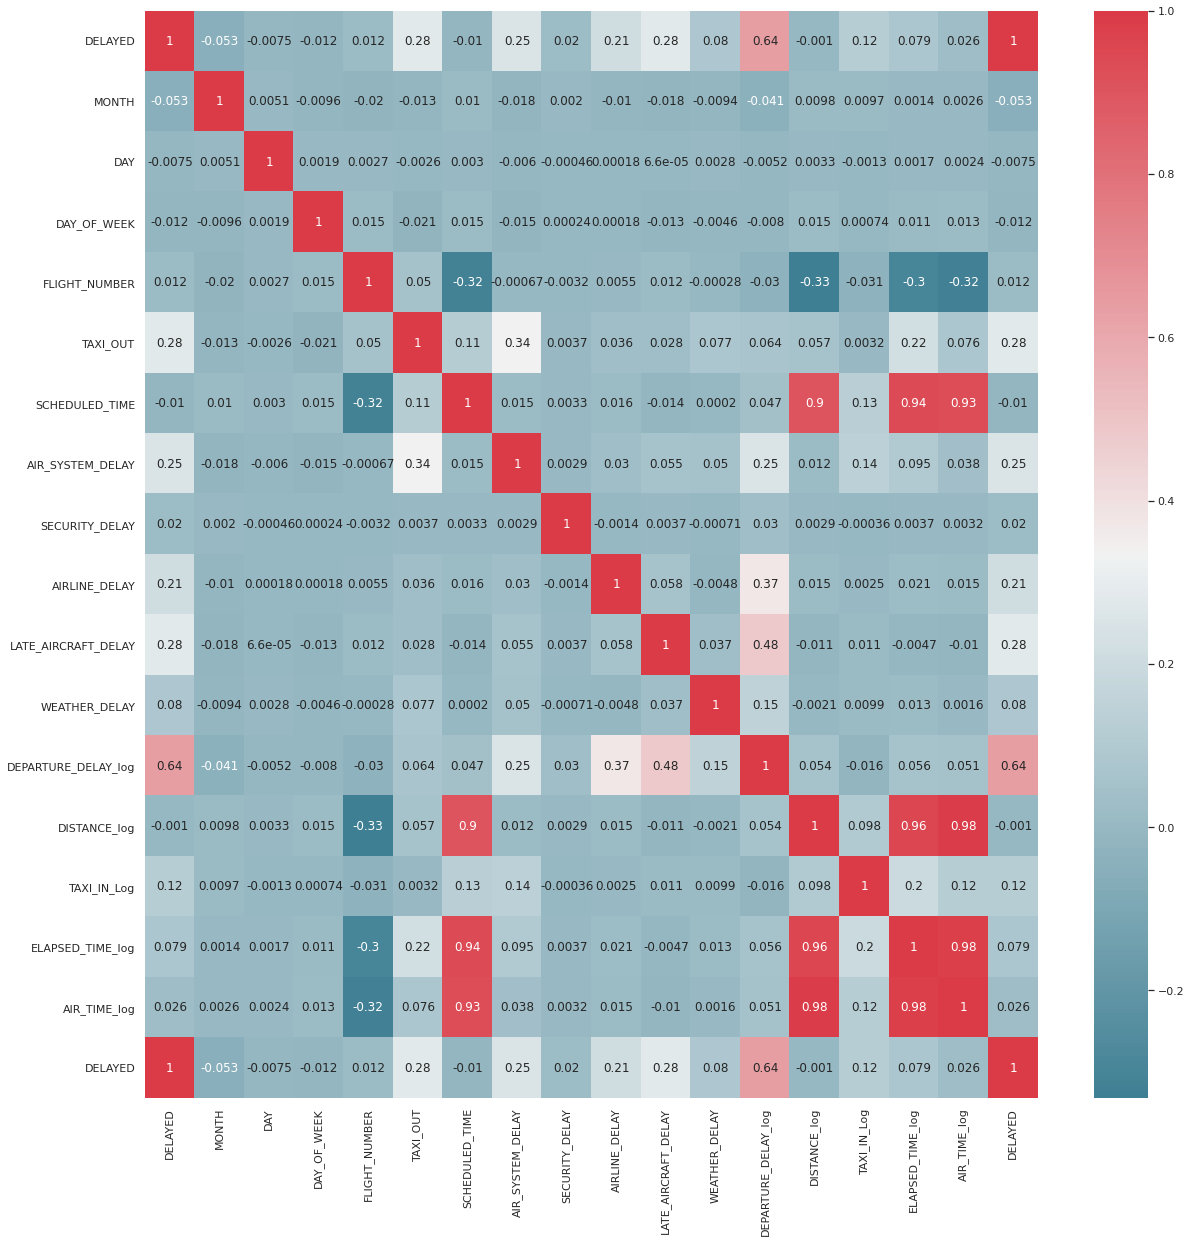

In [23]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Subset for response and continuous variables
num = df_OHE[['DELAYED', 'MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'TAXI_OUT','SCHEDULED_TIME',
           'AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 'DEPARTURE_DELAY_log',
          'DISTANCE_log', 'TAXI_IN_Log','ELAPSED_TIME_log',
          'AIR_TIME_log','DELAYED']]

# Create heatmap
sns.heatmap(num.corr(), cmap=cmap, annot = True)

`SCHEDULED_TIME`, `ELAPSED_TIME_log`, `AIR_TIME_log`, `DISTANCE_log` are all highly correlated. For the purposes here we want to only keep `DISTANCE_log`, the decision to keep this variable was that we would not know the Air Time and Elapsed Time since we are trying to predict if the plane would be delayed prior to flight and distance would always be known. 

In [24]:
# Drop SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, and their log versions as well as DEPARTURE_DELAY
col_to_drop2 = ['SCHEDULED_TIME', 'ELAPSED_TIME_log', 'AIR_TIME_log']
df_OHE = df_OHE.drop(columns = col_to_drop2)

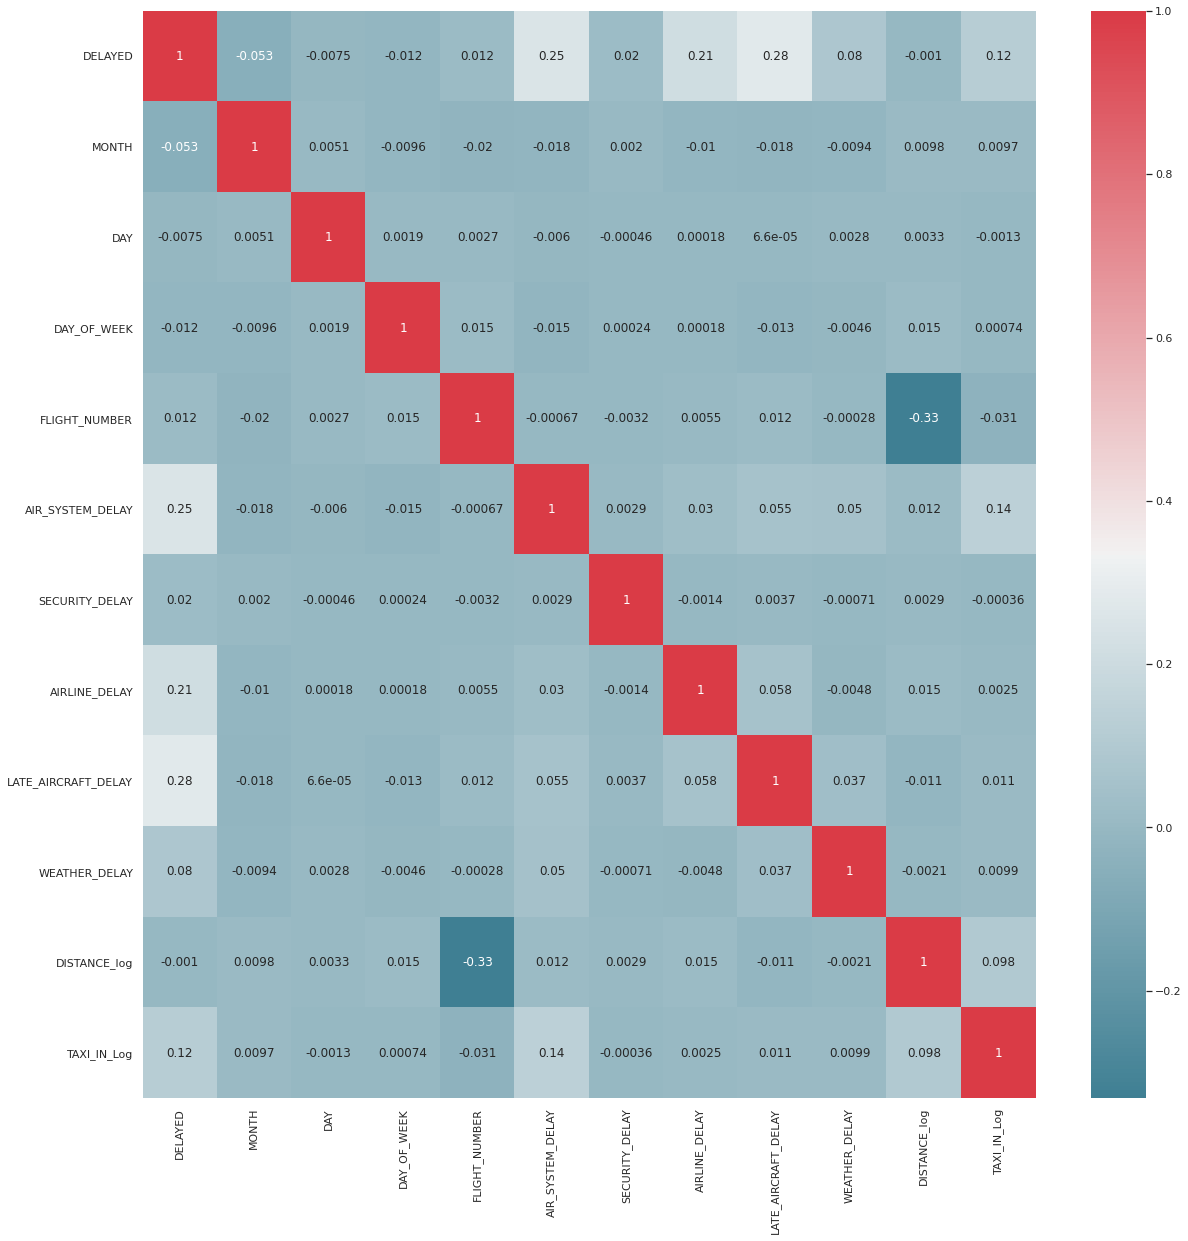

In [25]:
# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Subset for the remaining continuous variables
num = df_OHE[['DELAYED', 'MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'AIR_SYSTEM_DELAY',
          'SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY',
         'DISTANCE_log', 'TAXI_IN_Log']]

# Create heatmap
sns.heatmap(num.corr(), cmap=cmap, annot = True)

In [26]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 47 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   TAXI_OUT                         float64
 5   DIVERTED                         int64  
 6   AIR_SYSTEM_DELAY                 float64
 7   SECURITY_DELAY                   float64
 8   AIRLINE_DELAY                    float64
 9   LATE_AIRCRAFT_DELAY              float64
 10  WEATHER_DELAY                    float64
 11  DEPARTURE_DELAY_log              float64
 12  DISTANCE_log                     float64
 13  TAXI_IN_Log                      float64
 14  ORIGIN_AIRPORT_encode            int64  
 15  DESTINATION_AIRPORT_encode       float64
 16  TAIL_NUMBER_encode               int64  
 17  AIRLINE_

In [27]:
## This is needed in order to run VIF but keeps crashing due to amount of RAM so just commenting section out for now

#convert our unicode values to integers for VIF
#df_OHE2 = df_OHE

#cols_uni = df_OHE2.columns[13:37]
#cols_uni

#df_OHE2[cols_uni] = df_OHE2[cols_uni].apply(pd.to_numeric, errors = 'coerce', axis =1)

In [28]:
#df_OHE2.head()

In [29]:
#df_OHE2.info()

In [30]:
#%%time
# Run our VIF code
# Calculate the VIF
# Source: https://www.statology.org/how-to-calculate-vif-in-python/ 

#from patsy import dmatrices
#from statsmodels.stats.outliers_influence import variance_inflation_factor

#features = "+".join(df.columns - ['DELAYED'])
#features = df_OHE2.iloc[:,:11]

#find design matrix for linear regression model using 'rating' as response variable 
#y, X = dmatrices('DELAYED ~' + features, data=df_OHE2, return_type='dataframe')

#calculate VIF for each explanatory variable
#vif = pd.DataFrame()
#vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#vif['features'] = X.columns

#view VIF for each explanatory variable 
#vif

In [31]:
features = df_OHE.iloc[:,:12]
features

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAXI_OUT,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DEPARTURE_DELAY_log
0,1,1,4,98,21.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,1,4,2336,12.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
2,1,1,4,840,16.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
3,1,1,4,258,15.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
4,1,1,4,135,11.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5712235,12,31,4,688,22.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
5712236,12,31,4,745,17.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
5712237,12,31,4,1503,17.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
5712238,12,31,4,333,10.0,0,0.0,0.0,0.0,0.0,0.0,0.000000


The `AIRLINE_CODE_`, `SCHED_DEPARTURE_TIME_`, `ACTUAL_DEPARTURE_TIME_`, and `SCHED_ARRIVAL_TIME_` one-hot encodings are returning perfect multicollinearity so we'll remove one of each and re-run the VIF. After thinking this through, it makes sense that the actual departure and arrival times are a dead giveaway for delays. Same with our other delay types (`AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY`, `WEATHER_DELAY`, and `ARRIVAL_DELAY` buckets).

In [32]:
# Drop the remaining highly correlated variables
col_to_drop4 = ['ACTUAL_DEPARTURE_TIME_morning', 'ACTUAL_DEPARTURE_TIME_afternoon', 'ACTUAL_DEPARTURE_TIME_evening', 'ACTUAL_DEPARTURE_TIME_overnight', 
                 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df_OHE = df_OHE.drop(columns = col_to_drop4)

df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 38 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   MONTH                           int64  
 1   DAY                             int64  
 2   DAY_OF_WEEK                     int64  
 3   FLIGHT_NUMBER                   int64  
 4   TAXI_OUT                        float64
 5   DIVERTED                        int64  
 6   DEPARTURE_DELAY_log             float64
 7   DISTANCE_log                    float64
 8   TAXI_IN_Log                     float64
 9   ORIGIN_AIRPORT_encode           int64  
 10  DESTINATION_AIRPORT_encode      float64
 11  TAIL_NUMBER_encode              int64  
 12  AIRLINE_CODE_AA                 uint8  
 13  AIRLINE_CODE_AS                 uint8  
 14  AIRLINE_CODE_B6                 uint8  
 15  AIRLINE_CODE_DL                 uint8  
 16  AIRLINE_CODE_EV                 uint8  
 17  AIRLINE_CODE_F9            

### 1.10 Test/Train Split

Our desired variable for classication will be our binary value for delay to determine whether or not a flight was delayed on arrival.

In [33]:
# Prep for the split by moving the response variable to the last column.
cols = list(df_OHE.columns.values) 
cols.pop(cols.index('DELAYED')) 
df_final = df_OHE[cols+['DELAYED']]

In [34]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 38 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   MONTH                           int64  
 1   DAY                             int64  
 2   DAY_OF_WEEK                     int64  
 3   FLIGHT_NUMBER                   int64  
 4   TAXI_OUT                        float64
 5   DIVERTED                        int64  
 6   DEPARTURE_DELAY_log             float64
 7   DISTANCE_log                    float64
 8   TAXI_IN_Log                     float64
 9   ORIGIN_AIRPORT_encode           int64  
 10  DESTINATION_AIRPORT_encode      float64
 11  TAIL_NUMBER_encode              int64  
 12  AIRLINE_CODE_AA                 uint8  
 13  AIRLINE_CODE_AS                 uint8  
 14  AIRLINE_CODE_B6                 uint8  
 15  AIRLINE_CODE_DL                 uint8  
 16  AIRLINE_CODE_EV                 uint8  
 17  AIRLINE_CODE_F9            

In [35]:
#X = df_final.iloc[:,:-1]
#X.head()

In [36]:
from sklearn.model_selection import ShuffleSplit

# We want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y = df_final['DELAYED'].values # get the labels we want
    #del df_final['DELAYED'] # get rid of the class label
    X = df_final.iloc[:,:-1].values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
# To use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits.
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)


In [37]:
X.shape

(5712230, 37)

In [38]:
y.shape

(5712230,)

In [39]:
features = list(df_final.iloc[:,:-1])
features

['MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'FLIGHT_NUMBER',
 'TAXI_OUT',
 'DIVERTED',
 'DEPARTURE_DELAY_log',
 'DISTANCE_log',
 'TAXI_IN_Log',
 'ORIGIN_AIRPORT_encode',
 'DESTINATION_AIRPORT_encode',
 'TAIL_NUMBER_encode',
 'AIRLINE_CODE_AA',
 'AIRLINE_CODE_AS',
 'AIRLINE_CODE_B6',
 'AIRLINE_CODE_DL',
 'AIRLINE_CODE_EV',
 'AIRLINE_CODE_F9',
 'AIRLINE_CODE_HA',
 'AIRLINE_CODE_MQ',
 'AIRLINE_CODE_NK',
 'AIRLINE_CODE_OO',
 'AIRLINE_CODE_UA',
 'AIRLINE_CODE_US',
 'AIRLINE_CODE_VX',
 'AIRLINE_CODE_WN',
 'SCHED_DEPARTURE_TIME_overnight',
 'SCHED_DEPARTURE_TIME_morning',
 'SCHED_DEPARTURE_TIME_afternoon',
 'SCHED_DEPARTURE_TIME_evening',
 'SCHED_ARRIVAL_TIME_overnight',
 'SCHED_ARRIVAL_TIME_morning',
 'SCHED_ARRIVAL_TIME_afternoon',
 'SCHED_ARRIVAL_TIME_evening',
 'DISTANCE_BUCKET_Short',
 'DISTANCE_BUCKET_Medium',
 'DISTANCE_BUCKET_Long']

In [40]:
#alternate test/train split for use in lasso regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### 1.11 Lasso Regression

For additional feature selection, we will run LASSO regression to determine if we need to further reduce our features within the data set. 

In [41]:
#Source: https://www.yourdatateacher.com/2021/05/05/feature-selection-in-machine-learning-using-lasso-regression/ 

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#define pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

grid = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)}, #test values of alpha from 0.1 to 10
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [42]:
#run grid search
#grid.fit(X_train,y_train)

In [43]:
#find best value of alpha
#grid.best_params_

In [44]:
#find coefficients
#coefficients = grid.best_estimator_.named_steps['model'].coef_
#coefficients

In [45]:
#find the most important features
#np.array(features)[coefficients > 0]

Based on LASSO regression, the only important features in our data set are `TAXI-OUT` and `DEPARTURE_DELAY_log`. This is possibly an indicator that our data set for predicting `DELAY` may not be the best. We do not want to remove all other variables at this point, but this is an interesting finding to keep in mind for the remainder of our analysis. Let's run PCA next to see if it shows any promise for dimension reduction.

### 1.12 PCA

In [46]:
# Standardize the features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create the object
scaler = StandardScaler()

# Calculate the mean and standard deviation
scaler.fit(df_final.iloc[:,:-1]) #scale everything except response variable
df_pca_scaled = scaler.transform(df_final.iloc[:,:-1])

# Calculate the PCA that explains 95% of the variance
pca_95 = PCA(n_components=0.95, random_state=2015)
pca_95.fit(df_pca_scaled)
df_pca_95 = pca_95.transform(df_pca_scaled)

# Display the PCA values
np.cumsum(pca_95.explained_variance_ratio_*100)

array([ 8.98904972, 16.87338567, 22.50483458, 27.4868927 , 32.04993396,
       36.02697391, 39.92814594, 43.61029312, 46.91890225, 50.09240714,
       53.23293702, 56.2378112 , 59.23256819, 62.14765254, 65.02618407,
       67.8643804 , 70.67806787, 73.45446262, 76.22395773, 78.98324411,
       81.65217484, 84.24192365, 86.5800357 , 88.72800751, 90.8254909 ,
       92.88294714, 94.87316269, 96.7127538 ])

In this version of our data set, it takes 28 principal components to get up to 95% explained variability.

Text(0, 0.5, 'Explained Variance')

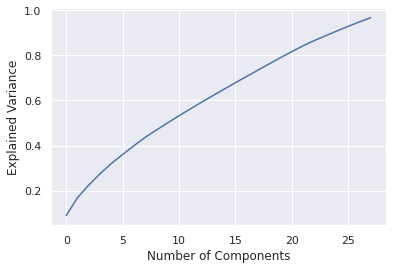

In [47]:
# Plot PCA results
plt.plot(np.cumsum(pca_95.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [48]:
df_post_pca = pd.DataFrame(df_pca_95, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
                                                 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15',
                                                 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22',
                                                 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28'])
df_post_pca['Delayed'] = df_final.DELAYED
df_post_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Delayed
0,3.609769,-2.443451,-1.695949,-1.639898,0.055845,-0.161267,0.911516,0.666445,0.546937,-2.040368,-4.224530,2.959413,9.284651,2.101439,5.238942,0.799259,-3.781516,-1.690615,2.467831,6.107657,7.565242,1.882498,0.373663,-3.377413,-0.139191,0.000205,2.853126,0.035745,0.0
1,3.455453,-2.458344,-1.456305,-1.672021,1.271297,-0.760421,0.140543,0.258987,-1.226247,-1.962383,-3.228313,5.264796,5.705031,1.949376,6.108941,-0.439638,-2.550432,-1.268272,0.160887,7.107252,8.629368,-0.163975,-1.265021,-3.384477,-0.479260,0.658617,1.485193,-0.311974,0.0
2,3.616934,-2.549772,-1.623507,-2.081723,0.806378,0.000110,-0.070049,2.431868,0.290205,0.077004,-4.366121,7.786380,4.918931,2.286673,4.897154,0.123388,-4.131614,-1.379360,2.673682,6.534059,7.890720,-0.866192,0.022693,-2.927653,2.527630,0.346128,1.344184,1.046194,1.0
3,3.935454,-2.600275,-1.532814,-1.229612,1.237222,-0.794676,0.248912,1.024572,-1.654687,-1.759163,-3.116145,5.281418,5.637600,1.982772,6.051377,-0.364234,-2.433270,-1.254712,0.173828,6.933079,8.563683,-0.391714,-0.569587,-3.462834,-0.141799,0.800028,2.112781,-0.272909,0.0
4,4.317083,-1.234068,-1.176625,-1.528833,-0.504365,-0.426565,0.813690,-0.862122,1.022784,-1.347724,-1.196321,4.042615,11.224396,5.873542,0.779014,0.002959,-2.593895,-1.914241,2.277828,7.380133,8.557572,-0.625707,2.000488,-2.327584,-0.577008,-0.154607,2.840544,-0.186741,0.0


Text(0, 0.5, 'Second Principal Component')

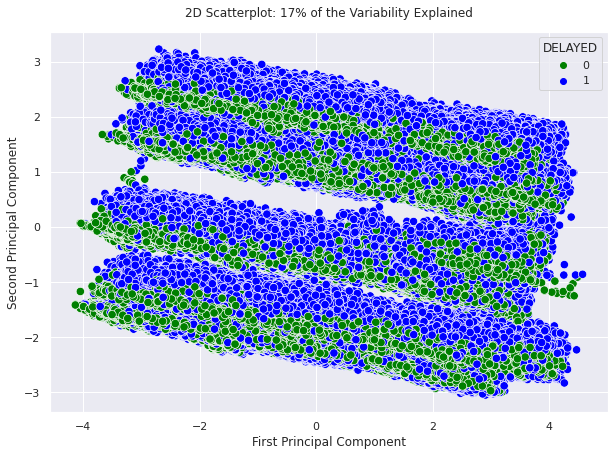

In [49]:
#plot first two principal components
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca_95[:, 0], y=df_pca_95[:, 1], s=70,
               hue=df_final.DELAYED, palette=['green', 'blue'])

plt.title("2D Scatterplot: 17% of the Variability Explained", pad=15)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

This is an interesting plot, but we don't see clear separation for our desired response variable. Therefore, PCA is not useful for dimension reduction on this data set.

### 1.13 Logistic Regression

First, we will run a fairly standard logistic regression model with 3-fold cross validation.

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# Define our model
lr_clf = LogisticRegression(penalty='l2', 
                            C=1.0, 
                            class_weight=None,
                            solver='liblinear')

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8557874945511648
confusion matrix
 [[666514  59018]
 [105737 311177]]
====Iteration 1  ====
accuracy 0.8545856872009705
confusion matrix
 [[665690  59124]
 [107004 310628]]
====Iteration 2  ====
accuracy 0.8548123937586547
confusion matrix
 [[665619  59243]
 [106626 310958]]


In [51]:
#check memory usage
dir()

['GridSearchCV',
 'In',
 'LabelEncoder',
 'Lasso',
 'LogisticRegression',
 'Out',
 'PCA',
 'Pipeline',
 'ShuffleSplit',
 'StandardScaler',
 'X',
 'X_test',
 'X_train',
 '_',
 '_12',
 '_13',
 '_15',
 '_21',
 '_22',
 '_23',
 '_25',
 '_3',
 '_31',
 '_37',
 '_38',
 '_39',
 '_46',
 '_47',
 '_48',
 '_49',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i46',
 '_i47',
 '_i48',
 '_i49',
 '_i5',
 '_i50',
 '_i51',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 '_sh',
 'actual_depart',
 'airlines',
 'airports',
 'alt',
 'ax',
 'categori

In [52]:
#remove some variables to save memory
del pca_95
del df_pca_95
del df_pca_scaled
del df2

Across three separate iterations of 3-fold cross validation gives us around 85% accuracy which is pretty decent. Let's set up a gridsearch to test multiple cost values.

This crashes due to using all RAM every time

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#define pipeline
#pipeline = Pipeline([
#                     ('scaler',StandardScaler()),
#                     ('model',LogisticRegression())
#])

#param_grid = [{'model__C': [1, 10, 100], 
#               'model__solver': ['sag', 'saga','liblinear'], 
#               'model__penalty' : ['l1', 'l2']}]

#grid = GridSearchCV(pipeline,
#                    param_grid,
#                    cv=3,
#                    n_jobs=-1,
#                    verbose=2,
#                    scoring="accuracy")

#run grid search
#grid.fit(X_train,y_train)

Code below adapted from class notebook `04. Logits and SVM.ipynb`. Run logistic regression again, this time with 5 iterations but using the `SGDClassifier` with log loss setting instead of `LogisticRegression`.

In [54]:
#create new cv object for our split
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit(n_splits=1,test_size=0.2)

In [55]:
%%time
# use some compact notation for creating a logistic regression classifier with stochastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8461476516176695
CPU times: user 26.5 s, sys: 628 ms, total: 27.1 s
Wall time: 26.6 s


In [56]:
#re-run with 10 iterations

regularize_const = 0.1
iterations = 10

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8457213732640317


In [57]:
#re-run with new regularize value

regularize_const = 0.01

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2',
        early_stopping=True)

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8554294907593006


In [58]:
#re-run with new regularize value

regularize_const = 0.001

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2',
        early_stopping=True)

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8568413736841829


Not significant changes here. Let's change penalty type to see if that changes accuracy.

In [59]:
#re-run with l1 penalty

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l1',
        early_stopping=True)

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8565323875264126


No big changes here either. Let's run with more folds on CV next.

In [60]:
#test use 10-fold cv object
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=10, test_size=0.2, train_size=None)


In [61]:
%%time

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8562557880197401
CPU times: user 6min 24s, sys: 4 s, total: 6min 28s
Wall time: 6min 21s


In [62]:
# Iterate over the coefficients and interpret the weights
weights = log_sgd.coef_.T # take transpose to make a column vector
variable_names = df_final.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

MONTH has weight of -0.0977250309192133
DAY has weight of -0.01133258328531265
DAY_OF_WEEK has weight of -0.009764779961335552
FLIGHT_NUMBER has weight of -0.008341294661678201
TAXI_OUT has weight of 1.347589980971144
DIVERTED has weight of 0.0
DEPARTURE_DELAY_log has weight of 2.172114871382256
DISTANCE_log has weight of -0.20320197870802148
TAXI_IN_Log has weight of 0.6719540952528326
ORIGIN_AIRPORT_encode has weight of 0.01933691295404987
DESTINATION_AIRPORT_encode has weight of 0.04201640124521491
TAIL_NUMBER_encode has weight of -0.020560440949269027
AIRLINE_CODE_AA has weight of -0.09751834314181444
AIRLINE_CODE_AS has weight of 0.12450409500181238
AIRLINE_CODE_B6 has weight of 0.015637742247909932
AIRLINE_CODE_DL has weight of -0.20225102656470473
AIRLINE_CODE_EV has weight of 0.04383818761047699
AIRLINE_CODE_F9 has weight of 0.06355014730876643
AIRLINE_CODE_HA has weight of 0.16785875116713825
AIRLINE_CODE_MQ has weight of -0.05083015490200924
AIRLINE_CODE_NK has weight of 0.08

In [63]:
df_weights = df_final.iloc[:,:-1]

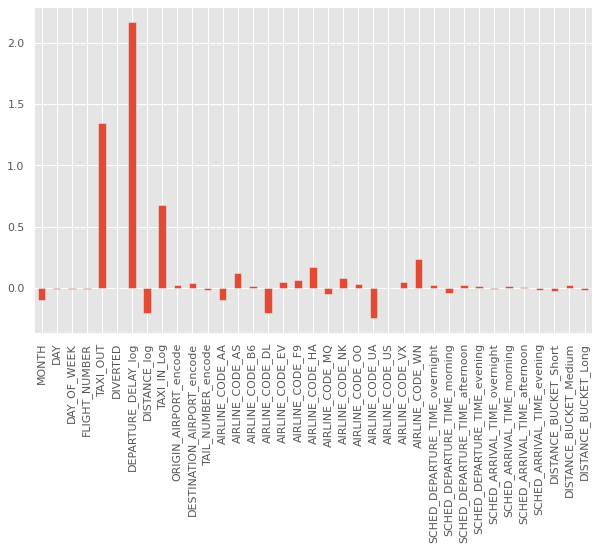

In [64]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(10,6))

weights = pd.Series(log_sgd.coef_[0],index=df_weights.columns)
weights.plot(kind='bar')
plt.show()

`TAXI_OUT`, `DEPARTURE_DELAY_log`, and `TAXI_IN_Log` all have very high coefficients. `DIVERTED` has a coefficient of `0` in this model. Let's test re-running logistic regression and feature importance after removing the above four variables. 

In [65]:
#find location of these variables
df_final.iloc[:,4] #TAXI_OUT
df_final.iloc[:,6] #DEPARTURE_DELAY_log
df_final.iloc[:,8] #TAXI_IN_Log
df_final.iloc[:,37] #DELAYED

0          0
1          0
2          1
3          0
4          0
          ..
5712235    0
5712236    0
5712237    0
5712238    0
5712239    1
Name: DELAYED, Length: 5712230, dtype: int64

In [66]:
#remove these variables and create new test/train split

vars_SUB = ['MONTH',
'DAY',
'DAY_OF_WEEK',
'FLIGHT_NUMBER',
'DISTANCE_log',
'ORIGIN_AIRPORT_encode',
'DESTINATION_AIRPORT_encode',
'TAIL_NUMBER_encode',
'AIRLINE_CODE_AA',
'AIRLINE_CODE_AS',
'AIRLINE_CODE_B6' ,
'AIRLINE_CODE_DL',
'AIRLINE_CODE_EV',
'AIRLINE_CODE_F9',
'AIRLINE_CODE_HA',
'AIRLINE_CODE_MQ',
'AIRLINE_CODE_NK',
'AIRLINE_CODE_OO',
'AIRLINE_CODE_UA',
'AIRLINE_CODE_US' , 
'AIRLINE_CODE_VX',
'AIRLINE_CODE_WN',
'SCHED_DEPARTURE_TIME_overnight',
'SCHED_DEPARTURE_TIME_morning',
'SCHED_DEPARTURE_TIME_afternoon',
'SCHED_DEPARTURE_TIME_evening',
'SCHED_ARRIVAL_TIME_overnight',
'SCHED_ARRIVAL_TIME_morning',
'SCHED_ARRIVAL_TIME_afternoon',
'SCHED_ARRIVAL_TIME_evening',
'DISTANCE_BUCKET_Short',
'DISTANCE_BUCKET_Medium',
'DISTANCE_BUCKET_Long'
]

# We want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y_sub = df_final['DELAYED'].values # get the labels we want
    X_sub = df_final[vars_SUB].values # use everything else to predict!

In [67]:
X_sub.shape

(5712230, 33)

In [68]:
#memory check
dir()

['GridSearchCV',
 'In',
 'LabelEncoder',
 'Lasso',
 'LogisticRegression',
 'Out',
 'PCA',
 'Pipeline',
 'SGDClassifier',
 'ShuffleSplit',
 'StandardScaler',
 'StratifiedShuffleSplit',
 'X',
 'X_sub',
 'X_test',
 'X_train',
 '_',
 '_12',
 '_13',
 '_15',
 '_21',
 '_22',
 '_23',
 '_25',
 '_3',
 '_31',
 '_37',
 '_38',
 '_39',
 '_46',
 '_47',
 '_48',
 '_49',
 '_51',
 '_65',
 '_67',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i46',
 '_i47',
 '_i48',
 '_i49',
 '_i5',
 '_i50',
 '_i51',
 '_i52',
 '_i53',
 '_i54',
 '_i55',
 '_i56',
 '_i57',
 '_i58',


In [69]:
del tempdf
del df
del df_OHE
del X
del y

In [70]:
%%time
num_cv_iterations = 3
num_instances = len(y_sub)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

regularize_const = 0.1
iterations = 5

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X_sub,y_sub):
    log_sgd.fit(scl.fit_transform(X_sub[train_idx]),y_sub[train_idx])
    yhat = log_sgd.predict(scl.transform(X_sub[test_idx]))
    
    conf = mt.confusion_matrix(y_sub[test_idx],yhat)
    acc = mt.accuracy_score(y_sub[test_idx],yhat)

print('Logistic Regression:', acc)

ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)
Logistic Regression: 0.6357368313250692
CPU times: user 1min 10s, sys: 1.18 s, total: 1min 12s
Wall time: 1min 10s


In [71]:
# Iterate over the coefficients and interpret the weights
weights = log_sgd.coef_.T # take transpose to make a column vector
variable_names = df_final[vars_SUB]
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

MONTH has weight of -0.06739483944188399
DAY has weight of -0.010420931782985206
DAY_OF_WEEK has weight of -0.019791568288517938
FLIGHT_NUMBER has weight of 0.009764644961529876
DISTANCE_log has weight of 0.0016235271988581002
ORIGIN_AIRPORT_encode has weight of 0.025565581109942816
DESTINATION_AIRPORT_encode has weight of 0.03667122278282722
TAIL_NUMBER_encode has weight of -0.015536175218894657
AIRLINE_CODE_AA has weight of -0.007884347731379759
AIRLINE_CODE_AS has weight of -0.02022267536991986
AIRLINE_CODE_B6 has weight of 0.015598967474789121
AIRLINE_CODE_DL has weight of -0.08504765903297924
AIRLINE_CODE_EV has weight of 0.015189028577325183
AIRLINE_CODE_F9 has weight of 0.03552546602584598
AIRLINE_CODE_HA has weight of 0.012392113891516555
AIRLINE_CODE_MQ has weight of 0.0044698262407214286
AIRLINE_CODE_NK has weight of 0.05497008214993594
AIRLINE_CODE_OO has weight of 0.01434636372844368
AIRLINE_CODE_UA has weight of 0.0006019305665010302
AIRLINE_CODE_US has weight of 0.0065936

In [73]:
df_weights_2 = df_final[vars_SUB]

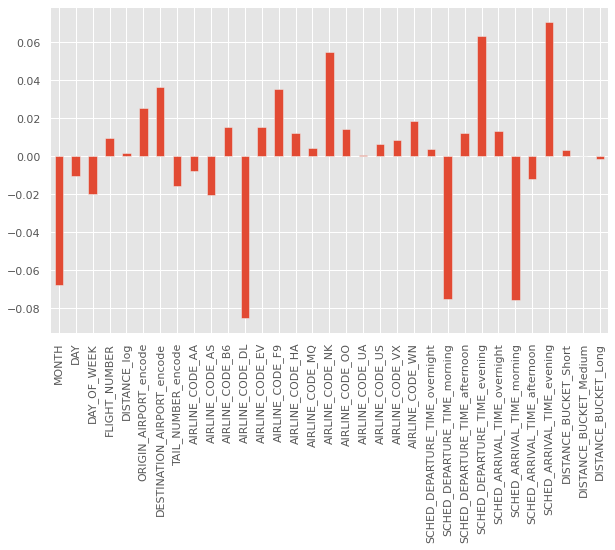

In [75]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(10,6))

weights = pd.Series(log_sgd.coef_[0],index=df_weights_2.columns)
weights.plot(kind='bar')
plt.show()

### 1.13 SVM

Run 'out of the box' SVM. Note that we have not scaled the data. Our data is all roughly on the same scale to begin with and should not be necessary.

In [ ]:
# use some compact notation for creating a linear SVM classifier with stochastic descent
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM Accuracy:', acc)
print(conf)

## 2. Advantages of Each Model

[10 points] Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

## 3. Feature Importance

> [30 points] Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?

### 3.1 Weights (Ordered)

| Variable                       | Coefficient  |
|--------------------------------|--------------|
| MONTH                          | -0.038797599 |
| DAY                            | -0.004623126 |
| DAY_OF_WEEK                    | -0.043852471 |
| FLIGHT_NUMBER                  | -7.59741E-05 |
| TAXI_OUT                       | 0.144409121  |
| DIVERTED                       | 0            |
| DEPARTURE_DELAY_log            | 1.383507196  |
| DISTANCE_log                   | -0.783440119 |
| TAXI_IN_Log                    | 1.264014238  |
| ORIGIN_AIRPORT_encode          | -0.000175709 |
| DESTINATION_AIRPORT_encode     | -5.47095E-05 |
| TAIL_NUMBER_encode             | -5.58957E-05 |
| AIRLINE_CODE_AA                | -0.299386121 |
| AIRLINE_CODE_AS                | 0.259878467  |
| AIRLINE_CODE_B6                | -0.084707295 |
| AIRLINE_CODE_DL                | -0.610397408 |
| AIRLINE_CODE_EV                | 0.062029928  |
| AIRLINE_CODE_F9                | 0.136878861  |
| AIRLINE_CODE_HA                | 0.161936974  |
| AIRLINE_CODE_MQ                | -0.141978443 |
| AIRLINE_CODE_NK                | 0.16124127   |
| AIRLINE_CODE_OO                | 0.107738791  |
| AIRLINE_CODE_UA                | -0.644212585 |
| AIRLINE_CODE_US                | -0.02960251  |
| AIRLINE_CODE_VX                | 0.079051418  |
| AIRLINE_CODE_WN                | 0.453810909  |
| SCHED_DEPARTURE_TIME_overnight | 0.020685601  |
| SCHED_DEPARTURE_TIME_morning   | -0.183262094 |
| SCHED_DEPARTURE_TIME_a         | -0.073692099 |
| SCHED_DEPARTURE_TIME_evening   | -0.151449152 |
| SCHED_ARRIVAL_TIME_overnight   | -0.033014929 |
| SCHED_ARRIVAL_TIME_morning     | -0.111094197 |
| SCHED_ARRIVAL_TIME_a           | -0.130313281 |
| SCHED_ARRIVAL_TIME_evening     | -0.113295337 |
| DISTANCE_BUCKET_Short          | -0.13067606  |
| DISTANCE_BUCKET_Medium         | -0.386151629 |
| DISTANCE_BUCKET_Long           | 0.129109945  |

### Weights (Largest to Smallest)

| Variable                       | Coefficient  |
|--------------------------------|--------------|
| DEPARTURE_DELAY_log            | 1.383507196  |
| TAXI_IN_Log                    | 1.264014238  |
| AIRLINE_CODE_WN                | 0.453810909  |
| AIRLINE_CODE_AS                | 0.259878467  |
| AIRLINE_CODE_HA                | 0.161936974  |
| AIRLINE_CODE_NK                | 0.16124127   |
| TAXI_OUT                       | 0.144409121  |
| AIRLINE_CODE_F9                | 0.136878861  |
| DISTANCE_BUCKET_Long           | 0.129109945  |
| AIRLINE_CODE_OO                | 0.107738791  |
| AIRLINE_CODE_VX                | 0.079051418  |
| AIRLINE_CODE_EV                | 0.062029928  |
| SCHED_DEPARTURE_TIME_overnight | 0.020685601  |
| DIVERTED                       | 0            |
| DESTINATION_AIRPORT_encode     | -5.47095E-05 |
| TAIL_NUMBER_encode             | -5.58957E-05 |
| FLIGHT_NUMBER                  | -7.59741E-05 |
| ORIGIN_AIRPORT_encode          | -0.000175709 |
| DAY                            | -0.004623126 |
| AIRLINE_CODE_US                | -0.02960251  |
| SCHED_ARRIVAL_TIME_overnight   | -0.033014929 |
|        MONTH                   | -0.038797599 |
| DAY_OF_WEEK                    | -0.043852471 |
| SCHED_DEPARTURE_TIME_a         | -0.073692099 |
| AIRLINE_CODE_B6                | -0.084707295 |
| SCHED_ARRIVAL_TIME_morning     | -0.111094197 |
| SCHED_ARRIVAL_TIME_evening     | -0.113295337 |
| SCHED_ARRIVAL_TIME_a           | -0.130313281 |
| DISTANCE_BUCKET_Short          | -0.13067606  |
| AIRLINE_CODE_MQ                | -0.141978443 |
| SCHED_DEPARTURE_TIME_evening   | -0.151449152 |
| SCHED_DEPARTURE_TIME_morning   | -0.183262094 |
| AIRLINE_CODE_AA                | -0.299386121 |
| DISTANCE_BUCKET_Medium         | -0.386151629 |
| AIRLINE_CODE_DL                | -0.610397408 |
| AIRLINE_CODE_UA                | -0.644212585 |
| DISTANCE_log                   | -0.783440119 |

## 4. Support Vectors

[10 points] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.